# Diffusion-based Speech Enhancement Demo

This demo presents advanced techniques in speech enhancement using deep generative models.

We compare SGMSE+ [1] with Schrödinger bridge approaches [2, 3]. 

The presented methods focus on generating high-quality super-wideband speech at a sampling rate of 48 kHz. 

Participants will record speech using a single microphone in a noisy environment, such as a conference venue. 

These recordings will then be enhanced and played back through headphones. 

We aim to demonstrate the model's effectiveness in improving speech quality and intelligibility.

```text
[1] J. Richter, S. Welker, J.-M. Lemercier, B. Lay, and T. Gerkmann, 
    “Speech enhancement and dereverberation with diffusion-based generative models,” 
    IEEE/ACM Transactions on Audio, Speech, and Language Processing, vol. 31, pp. 2351–2364, 2023.

[2] A. Jukić, R. Korostik, J. Balam, and B. Ginsburg, 
    “Schrödinger bridge for generative speech enhancement,” 
    Proceedings of Interspeech, pp. 1175-1179, 2024.    

[3] Julius Richter, Danilo de Oliveira, Timo Gerkmann, 
    “Investigating Training Objectives for Generative Speech Enhancement,”
    submitted to IEEE International Conference on Acoustics, Speech, and Signal Processing.
```

## Load packages

In [1]:
import os
import torch
import numpy as np
import soundfile as sf
import sounddevice as sd
import ipywidgets as widgets

from matplotlib import pyplot as plt
from sgmse.util.other import pad_spec, set_torch_cuda_arch_list, get_inference_objects
set_torch_cuda_arch_list()
from sgmse.util.visualization import plot_spec, plot_spec_dual, plot_audio
from sgmse.model import ScoreModel

from IPython.display import display, Audio

# Set device
os.environ["CUDA_VISIBLE_DEVICES"]="7"

Set TORCH_CUDA_ARCH_LIST to: 8.6;8.6;8.6;8.6;8.6;8.6;8.6;8.6


## Download the pre-trained models

In [2]:
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
    !wget -P checkpoints https://www2.informatik.uni-hamburg.de/sp/audio/publications/neurips2024-demo/checkpoints/sgmse.ckpt
    !wget -P checkpoints https://www2.informatik.uni-hamburg.de/sp/audio/publications/neurips2024-demo/checkpoints/sb.ckpt
    !wget -P checkpoints https://www2.informatik.uni-hamburg.de/sp/audio/publications/neurips2024-demo/checkpoints/sb-pesq.ckpt

## Load models

In [3]:
sb_checkpoint = 'checkpoints/sb.ckpt'
sb_pesq_checkpoint = 'checkpoints/sb-pesq.ckpt'
sgmse_checkpoint = 'checkpoints/sgmse.ckpt'

sb_model = ScoreModel.load_from_checkpoint(sb_checkpoint)
sb_pesq_model = ScoreModel.load_from_checkpoint(sb_pesq_checkpoint)
sgmse_model = ScoreModel.load_from_checkpoint(sgmse_checkpoint)

/export/home/jrichter/repos/sgmse/venv/lib/python3.11/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


## Record audio

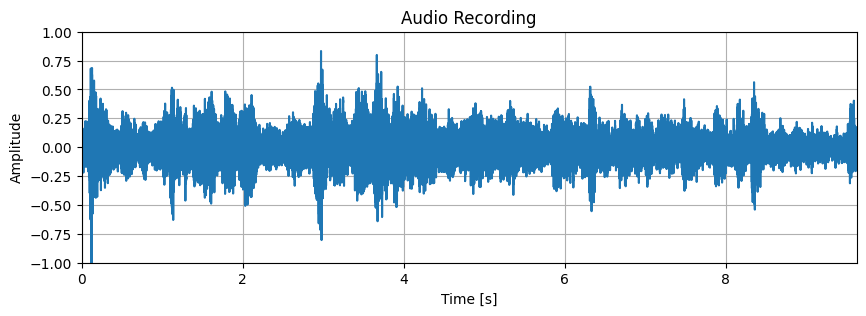

In [ ]:
duration = 10
sr = 48000
audio_data = sd.rec(int(duration*sr), samplerate=sr, channels=1)[:,0] 
sd.wait()

# file_path = 'examples/00000_-1.9dB.wav'
# audio_data, sr = sf.read(file_path)
# audio =  audio_data*1.85

plot_audio(audio, sr)


## Inference

In [5]:
model_slider = widgets.Dropdown(options=['SGMSE+', 'SB', 'SB-PESQ', ], value='SGMSE+', description='Model:', disabled=False)
sampler_type_slider = widgets.Dropdown(options=['ODE', 'SDE'], value='SDE', description='Sampler:', disabled=False)
N_slider = widgets.SelectionSlider(options=[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], value=30, description='N:', disabled=False, continuous_update=False, orientation='horizontal', readout=True)

display(model_slider)
display(sampler_type_slider)
display(N_slider)

Dropdown(description='Model:', options=('SGMSE+', 'SB', 'SB-PESQ'), value='SGMSE+')

Dropdown(description='Sampler:', index=1, options=('ODE', 'SDE'), value='SDE')

SelectionSlider(continuous_update=False, description='N:', index=6, options=(1, 5, 10, 15, 20, 25, 30, 35, 40,…

SB ODE 1


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


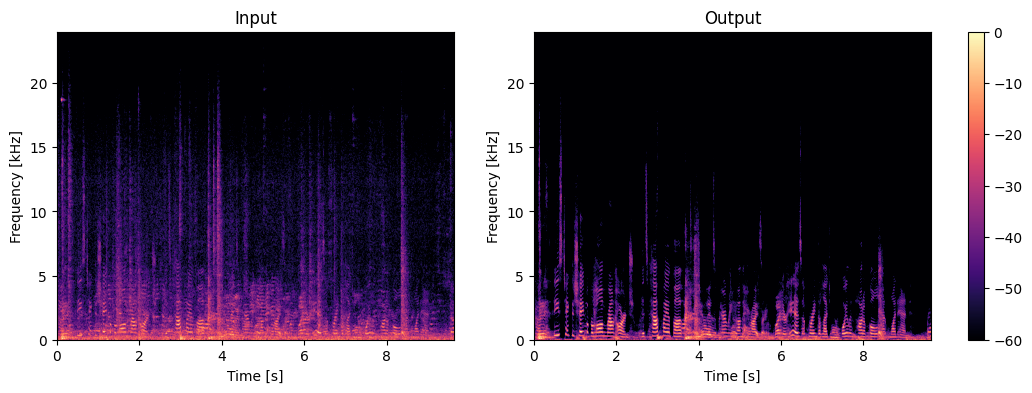

In [7]:
# Get inference objects
model, sampler_type, N = get_inference_objects(model_slider, sampler_type_slider, N_slider, sgmse_model, sb_model, sb_pesq_model)
print(model_slider.value, sampler_type_slider.value, N_slider.value)

# Transfer audio to GPU
audio_tensor = torch.tensor(audio, dtype=torch.float32).unsqueeze(0).cuda()

# Enhance audio
x_hat = model.enhance(audio_tensor, sampler_type=sampler_type, N=N)

# Play enhanced audio
display(Audio(audio, rate=sr))
display(Audio(x_hat, rate=sr))
plot_spec_dual(audio, sr, x_hat, sr, target_sr=sr)